<a href="https://colab.research.google.com/github/kirill-kozlitin/VTB/blob/main/check_autologreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Провести тестирование выборки на предмет применимости в тестах
1. Построить автологрег
2. Оценить фичи, которые входят

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install xlsxwriter

In [3]:
!pip install optbinning

In [4]:
import pandas as pd
import sys

path = 'drive/MyDrive/VTB/'
sys.path.append(path)

import vtb_mlkit
from vtb_mlkit.scorekit.model import LogisticRegressionModel
from vtb_mlkit.scorekit.data import DataSamples


(CVXPY) Jul 20 09:11:13 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 20 09:11:13 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [5]:
data = pd.read_csv(path + 'accepted_2007_to_2018Q4.csv.gz', compression='gzip', nrows=1*10**4)

In [6]:
# data[['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']]
data['loan_status'].value_counts(dropna=False)

Fully Paid            7189
Charged Off           1713
Current               1024
Late (31-120 days)      58
In Grace Period         12
Late (16-30 days)        4
Name: loan_status, dtype: int64

In [7]:
data['target'] = data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [8]:
bad_features = ['id', # понятно
                'member_id', # понятно
                'desc', # описание кредита
                'title', # описание кредита
                'last_pymnt_amnt', # сумма посл. платежа. (лик)
                'acc_now_delinq', # кол. просрочек сейчас (лик)
                'total_pymnt', # уплач. сумма (лик)
                'total_pymnt_inv', # уплач. проц (лик)
                'total_rec_prncp', # уплач. сумма (лик)
                'total_rec_int', # уплач. проц (лик)
                'total_rec_late_fee', # уплач. проц (лик)
                'next_pymnt_d', # дата след. платежа (лик)
                'last_pymnt_amnt', # сумма послед. платежа (лик)
                'last_fico_range_low', # рейтинг текущ. (лик)
                'last_fico_range_high', # рейтинг текущ. (лик)
                'loan_status', # текущ. статус (лик)
                ]

In [9]:
data.drop(bad_features, axis='columns', inplace=True)

In [10]:
ds = DataSamples(samples={'train': data}, target='target', result_folder='titanic_output', samples_split={}, bootstrap_split={}, ci_analytic=False)

logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-20 09:11:13] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-20 09:11:13] Selected 126 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

[INFO] [2023-07-20 09:11:15] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-20 09:11:15] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-20 09:11:15] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-20 09:11:15] Processing 126 features on 1 CPU...


100%|██████████| 126/126 [04:02<00:00,  1.92s/it]


[INFO] [2023-07-20 09:15:19] Excluded 48 features ['emp_length', 'issue_d', 'pymnt_plan', 'mths_since_last_record', 'pub_rec', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'tot_coll_amt', 'total_cu_tl', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_dpd',

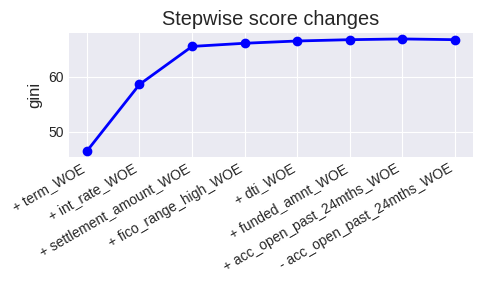

[INFO] [2023-07-20 09:16:06] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-20 09:16:06] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-20 09:16:06] Nothing to drop
[INFO] [2023-07-20 09:16:06] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-20 09:16:06] intercept = -0.86
[INFO] [2023-07-20 09:16:06] coefs = {'term_WOE': -0.768, 'settlement_amount_WOE': -0.978, 'int_rate_WOE': -0.578, 'funded_amnt_WOE': -0.18, 'fico_range_high_WOE': -0.672, 'dti_WOE': -0.569}
[INFO] [2023-07-20 09:16:06] Generating report...


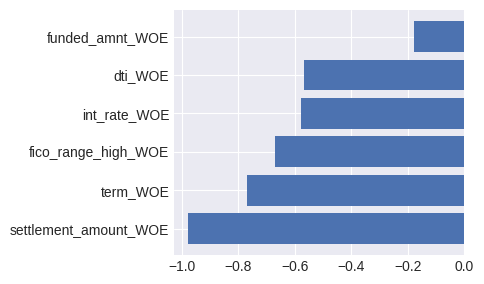

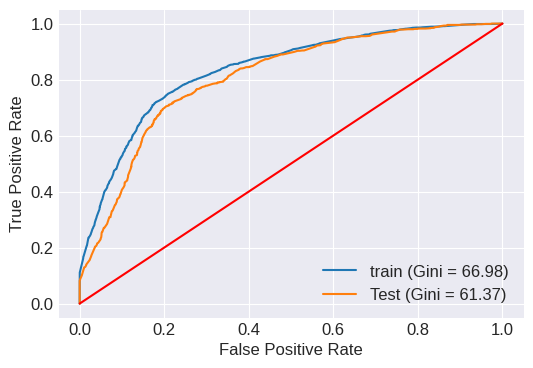

[INFO] [2023-07-20 09:16:12] 
      train   Test  CI_lower  CI_upper
Gini  66.98  61.37     63.48      67.2


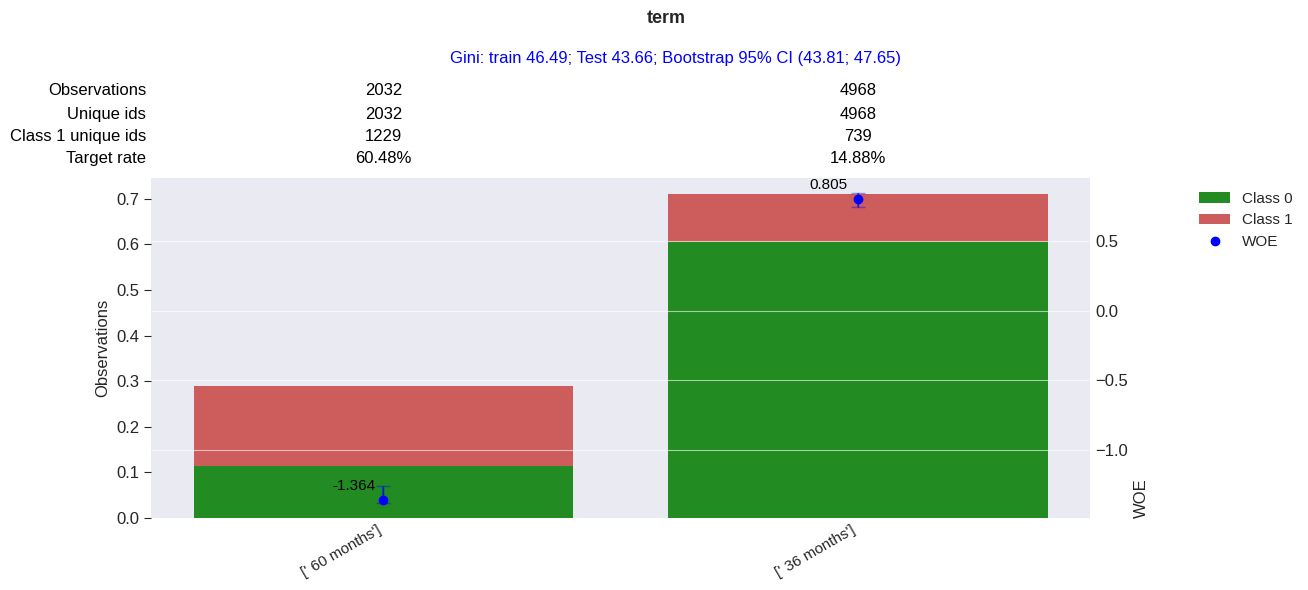

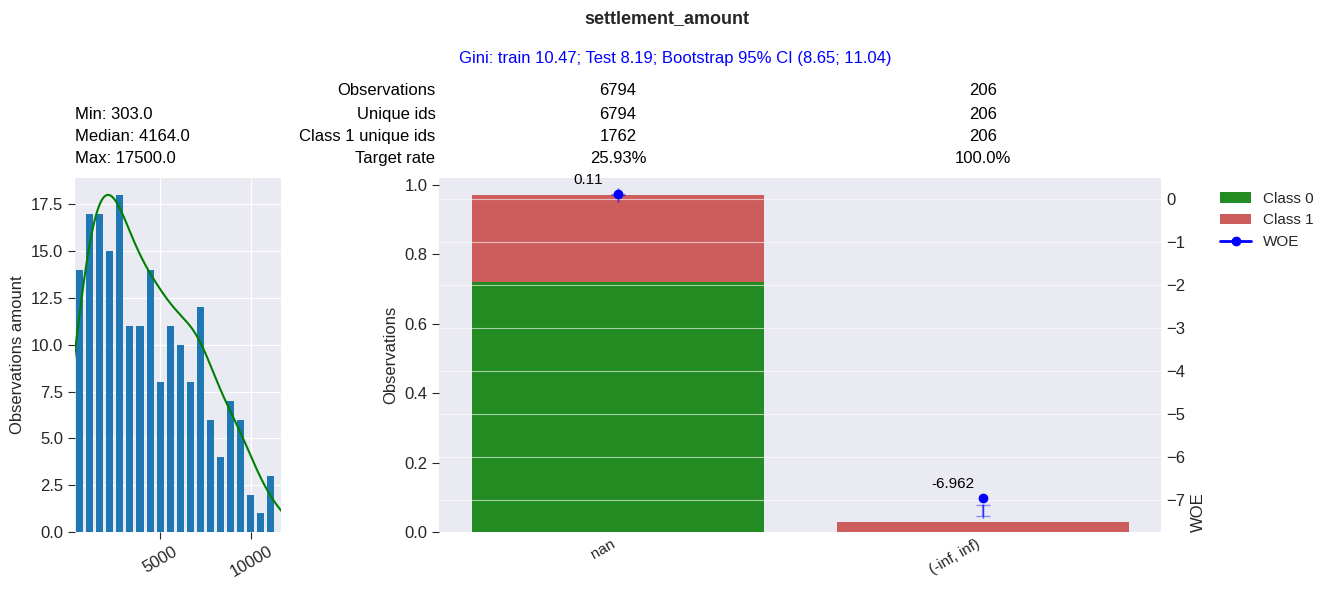

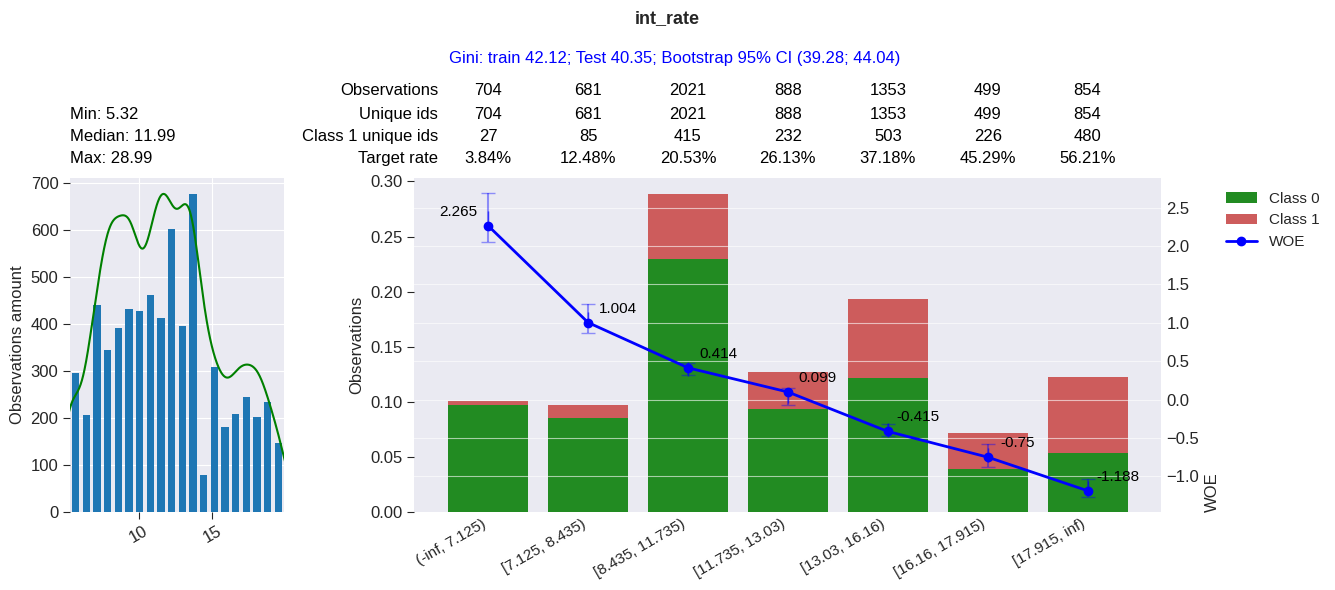

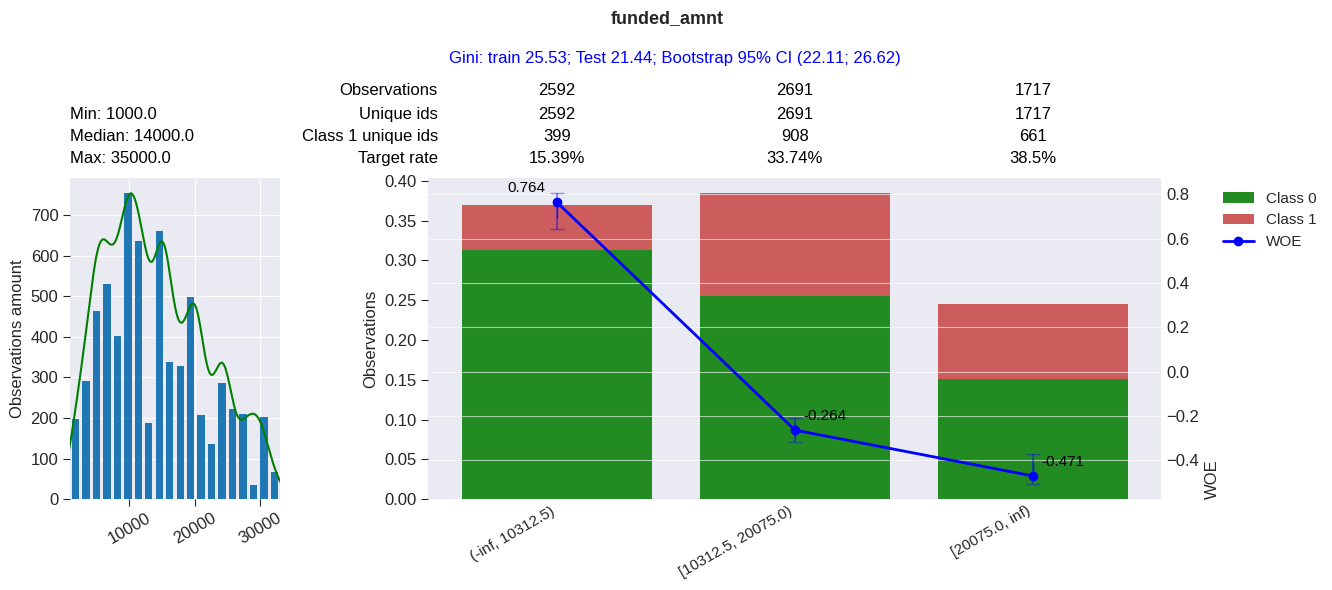

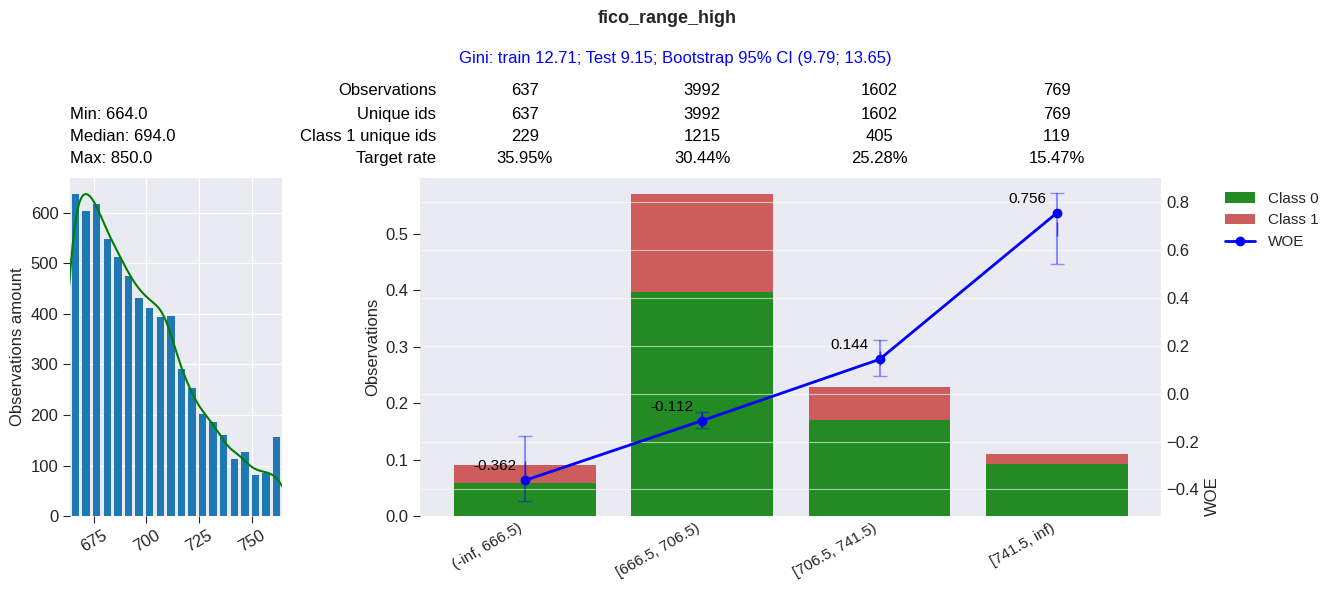

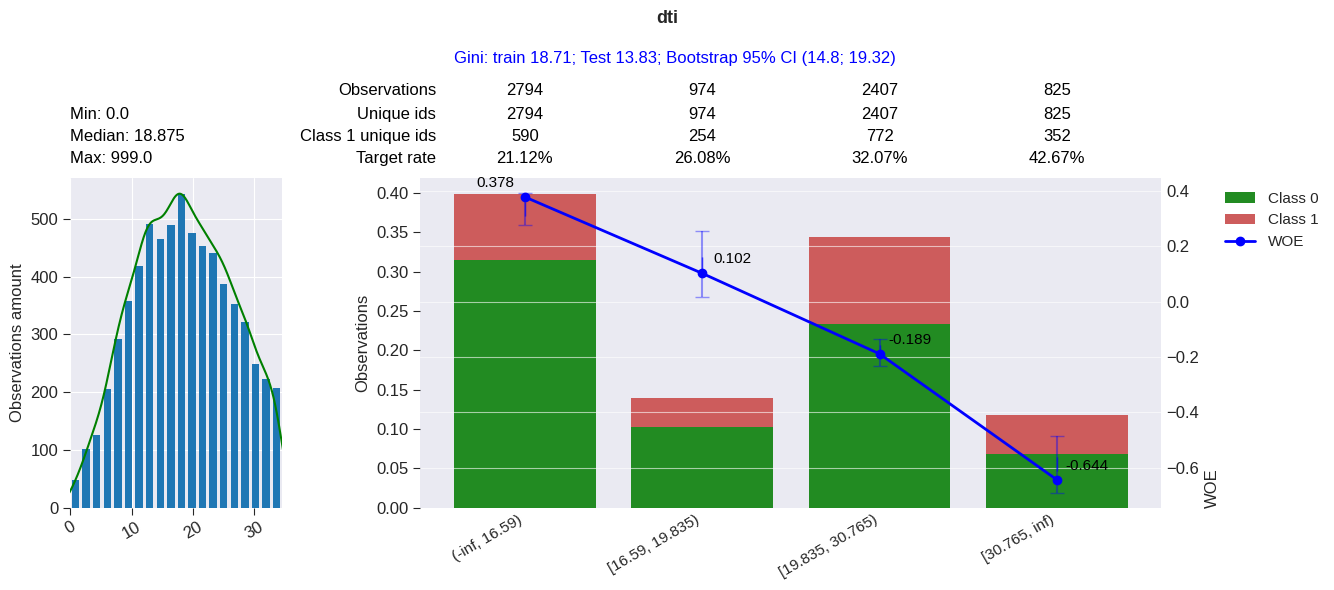

[INFO] [2023-07-20 09:16:37] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-20 09:16:37] The model was successfully saved to file titanic_output/auto_model.json


In [11]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=None, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [12]:
logreg.features

['term_WOE',
 'settlement_amount_WOE',
 'int_rate_WOE',
 'funded_amnt_WOE',
 'fico_range_high_WOE',
 'dti_WOE']

In [13]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op